# Jupyter Notebook for IPCC 6th Assessment Report Working Group 1  
# Figure 6.10b  
Creator Chaincy Kuo, Lawrence Berkeley National Laboratory  
Creation Date:  11 March 2021  

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gp
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import regionmask
from netCDF4 import Dataset
print(gp.__version__)  
from scipy import stats

ImportError: No module named 'geopandas'

In [3]:
regiondir='/anaconda2/envs/geo_env/lib/python3.8/site-packages/regionmask/defined_regions/data/AR6_WGI_referenceRegions'
df = gp.read_file("%s/AR6_WGI_referenceRegions.shp" % regiondir)
df["i"] = df.index # assing the index as column, so we can use it to color the regions

In [4]:
rgnnames=['ARCTIC','NORTH-AMERICA','CENTRAL-AMERICA','SOUTH-AMERICA','EUROPE','EUROPE-AFRICA',
          'AFRICA','ASIA','OCEANIA','ANTARCTICA','PACIFIC','ATLANTIC','INDIAN','SOUTHERN-OCEANS']
nlargergns=len(rgnnames)

erfswhatchpd=pd.DataFrame()
erflwhatchpd=pd.DataFrame()
erftothatchpd=pd.DataFrame()

for irgn in range(0,nlargergns):
    erflwhatchpd.loc[irgn,'Region']=rgnnames[irgn]
    erfswhatchpd.loc[irgn,'Region']=rgnnames[irgn]
    erftothatchpd.loc[irgn,'Region']=rgnnames[irgn]

In [5]:
# define a longitude latitude grid
lon = np.arange(-179.5, 180)
lat = np.arange(-89.5, 90)

# for the plotting
lon_edges = np.arange(-180, 181)
lat_edges = np.arange(-90, 91)

In [6]:
# dependence on the latitude and longitude grid
# take care that the regions are defined on the same lat and lon grid as the data.

# care must be taken in identifying input parameters for regionmask.Regions(). 
# The geometries and names/abbreviations must have unique ID's.  For example, if df.V1 is chosen, 
# the geometries are no longer unique and the associated geometry may not be correct.
ar6wg1regions = regionmask.Regions(df.geometry, names=df.V2, abbrevs=df.V1, name='ar6wg1')

In [7]:
ar6wg1mask = ar6wg1regions.mask(lon, lat, xarray=False)

In [8]:
# read the erf netcdf file

erfdir='/Users/chaincy/research/ipcc/figures/data/recipe_ck_erf_histSST-piAer_20210308_195740/plots/diffexpts/ar6fig6_erf'
ferf=Dataset('%s/erf_hatch_LW.nc' % erfdir,mode='r')
ferf=Dataset('%s/erf_hatch_SW.nc' % erfdir,mode='r')
nlat=ferf.dimensions['lat'].size
nlon=ferf.dimensions['lon'].size
ntime=ferf.dimensions['time'].size

lat=np.zeros((nlat,))
lon=np.zeros((nlon,))
erfsw=np.zeros((ntime,nlat,nlon))
hatchsw=np.zeros((ntime,nlat,nlon))

lat=ferf.variables['lat'][:]
lon=ferf.variables['lon'][:]
erfsw[0,:,:] = ferf.variables['erf_mn'][:]
hatchswnow = ferf.variables['significant'][:]

for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        if(hatchswnow[0,ilat,ilon]==0.0): # significant values are 0.0 in the mask
            hatchsw[0,ilat,ilon]= 1.0

In [9]:
hatchswnow.shape

(1, 180, 360)

In [10]:
# determine the quandrangle area weight 

areaweight = np.zeros((nlat,nlon),dtype=float);
lat4wt = np.zeros((nlat,2),dtype=float);
lon4wt = np.zeros((nlon,2),dtype=float);
# assumption that cells are equally spaced., but this is not correct for latitudes
dellon = 360.0/nlon;
for ilat in range(0,nlat):
    if(ilat==0):
        dellat1 = (90.0-np.abs(lat[ilat]))/2;
    else:
        dellat1 = np.abs(lat[ilat]-lat[ilat-1])/2;
    if(ilat==nlat-1):
        dellat2 = (90.0-np.abs(lat[ilat]))/2;
    else:
        dellat2 = np.abs(lat[ilat+1]-lat[ilat])/2;

    lat4wt[ilat,0] = (lat[ilat]-dellat1)/180.0 * np.pi;
    lat4wt[ilat,1] = (lat[ilat]+dellat2)/180.0 * np.pi;
for ilon in range(0,nlon):
    lon4wt[ilon,0] = (lon[ilon]-dellon/2)/180.0 * np.pi;
    lon4wt[ilon,1] = (lon[ilon]+dellon/2)/180.0 * np.pi;
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        areaweight[ilat,ilon] = np.abs(lon4wt[ilon,1]-lon4wt[ilon,0]) * np.abs(np.sin(lat4wt[ilat,1])-np.sin(lat4wt[ilat,0])) / (4.0*np.pi);       
        
np.sum(areaweight)

0.9999904807207345

In [11]:
# read the erf netcdf file

erfdir='/Users/chaincy/research/ipcc/figures/data/recipe_ck_erf_histSST-piAer_20210308_195740/plots/diffexpts/ar6fig6_erf'
ferf=Dataset('%s/erf_hatch_LW.nc' % erfdir,mode='r')
nlat=ferf.dimensions['lat'].size
nlon=ferf.dimensions['lon'].size
ntime=ferf.dimensions['time'].size

lat=np.zeros((nlat,))
lon=np.zeros((nlon,))
erflw=np.zeros((ntime,nlat,nlon))
hatchlw=np.zeros((ntime,nlat,nlon))

lat=ferf.variables['lat'][:]
lon=ferf.variables['lon'][:]
erflw[0,:,:] = ferf.variables['erf_mn'][:]
hatchlwnow = ferf.variables['significant'][:]

for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        if(hatchlwnow[0,ilat,ilon]==0.0): # significant values are 0.0 in the mask
            hatchlw[0,ilat,ilon]= 1.0

In [12]:
erfrgnspd=df.copy()
erfrgnspd['LW_ERF']=0.0
erfrgnspd['SW_ERF']=0.0
erfrgnspd['TOT_ERF']=0.0

nrgns=len(ar6wg1regions.numbers)
    
eartharea = 4*np.pi*np.power(6378,2)    
totalarea = 0
    
erflw_mns=np.zeros((nrgns,))
erflw_hatch=np.zeros((nrgns,nlat,nlon))
erflw_hatch=np.ma.asarray(erflw_hatch)
rgn_hatchlw=np.zeros((nrgns,nlat,nlon))
rgn_hatchlw=np.ma.asarray(rgn_hatchlw)

erfsw_mns=np.zeros((nrgns,))
erfsw_hatch=np.zeros((nrgns,nlat,nlon))
erfsw_hatch=np.ma.asarray(erfsw_hatch)
rgn_hatchsw=np.zeros((nrgns,nlat,nlon))
rgn_hatchsw=np.ma.asarray(rgn_hatchsw)

ilarge=0
hatchindlw=nlargergns 
hatchindsw=nlargergns 
hatchindtot=nlargergns
for irgn in range(0,nrgns):
    #LW
    maskerflw = np.ma.masked_where(ar6wg1mask != irgn, erflw[0,:,:])
    rgn_hatchlw[irgn,:,:] = np.ma.masked_where(ar6wg1mask != irgn, hatchlw[0,:,:])
    
    wtmask = np.ma.masked_where(ar6wg1mask != irgn, areaweight)

    erflw_mns[irgn] = np.sum(maskerflw*wtmask)/np.sum(wtmask)
    erfrgnspd.loc[irgn,'LW_ERF'] = erflw_mns[irgn]
    
    erflw_hatch[irgn,:,:] = (maskerflw*rgn_hatchlw[irgn,:,:])
    erflw_hatch[irgn,:,:] = np.ma.masked_equal(erflw_hatch[irgn,:,:],0)
    
    #SW
    maskerfsw = np.ma.masked_where(ar6wg1mask != irgn, erfsw[0,:,:])
    rgn_hatchsw[irgn,:,:] = np.ma.masked_where(ar6wg1mask != irgn, hatchsw[0,:,:])

    erfsw_mns[irgn] = np.sum(maskerfsw*wtmask)/np.sum(wtmask)
    erfrgnspd.loc[irgn,'SW_ERF'] = erfsw_mns[irgn]
    
    erfsw_hatch[irgn,:,:] = (maskerfsw*rgn_hatchsw[irgn,:,:])
    erfsw_hatch[irgn,:,:] = np.ma.masked_equal(erfsw_hatch[irgn,:,:],0)
       
    erfrgnspd.loc[irgn,'TOT_ERF'] = erflw_mns[irgn] + erfsw_mns[irgn]
        
    for ilat in range(0,nlat):
        for ilon in range(0,nlon):
            if(erflw_hatch.mask[irgn,ilat,ilon]==False ):
                erflwhatchpd.loc[hatchindlw,'Region']=df.loc[irgn,'V1'] # large region name
                erflwhatchpd.loc[hatchindlw,'sigLWERF']=erflw_hatch.data[irgn,ilat,ilon]
                hatchindlw = hatchindlw + 1
            if(erfsw_hatch.mask[irgn,ilat,ilon]==False ):    
                erfswhatchpd.loc[hatchindsw,'Region']=df.loc[irgn,'V1'] # large region name
                erfswhatchpd.loc[hatchindsw,'sigSWERF']=erfsw_hatch.data[irgn,ilat,ilon]
                hatchindsw = hatchindsw + 1
            if( (erflw_hatch.mask[irgn,ilat,ilon]==False) and (erfsw_hatch.mask[irgn,ilat,ilon]==False)):    
                erftothatchpd.loc[hatchindtot,'Region']=df.loc[irgn,'V1'] # large region name
                erftothatchpd.loc[hatchindtot,'sigTOTERF']=erfsw_hatch.data[irgn,ilat,ilon]+erflw_hatch.data[irgn,ilat,ilon]
                hatchindtot = hatchindtot + 1

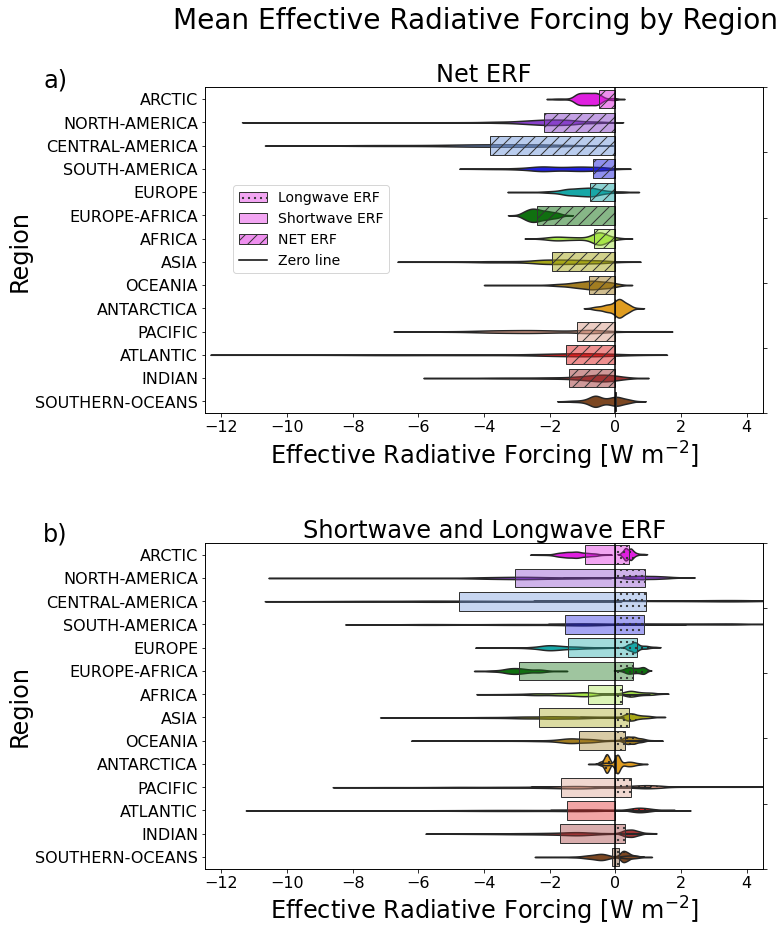

In [15]:

nrows=2
ncols=1

plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams["axes.labelsize"] = 24

# colors
nclr=['magenta','blueviolet','cornflowerblue','b','c','g','greenyellow','y','darkgoldenrod','orange','darksalmon','r','firebrick','saddlebrown']

ax=plt.figure(figsize=(ncols*10,nrows*7))
plt.subplots_adjust(wspace=0.3,hspace=0.4,top=0.9)
plt.suptitle('Mean Effective Radiative Forcing by Region',fontsize=28)

alpha=0.4
hatchbarlw='..'
hatchbarsw='//'

plt.subplot(nrows,ncols,2)
# lw barplot plus hatching, no errorbars    
lwax=sns.barplot(y="V1", x="LW_ERF", data=erfrgnspd, ci=None,  palette=nclr, label='Longwave ERF',edgecolor="0.2")
for i,thisbar in enumerate(lwax.patches):
    thisbar.set_hatch(hatchbarlw)
    r, g, b, a = thisbar.get_facecolor()
    thisbar.set_facecolor((r, g, b, alpha))    
# violin plots of the significant ERF grids
lwvl=sns.violinplot(y='Region',x='sigLWERF',data=erflwhatchpd,inner=None,  palette=nclr)
for i, violin in enumerate(lwvl.findobj(mpl.collections.PolyCollection)):
    violin.set_hatch(hatchbar)
    
# sw barplot , no errorbars
swax=sns.barplot(y="V1", x="SW_ERF", data=erfrgnspd, ci=None, palette=nclr, label='Shortwave ERF',edgecolor="0.2")
for i,thisbar in enumerate(swax.patches):
    
    r, g, b, a = thisbar.get_facecolor()
    thisbar.set_facecolor((r, g, b, alpha))
swvl=sns.violinplot(y='Region',x='sigSWERF',data=erfswhatchpd,inner=None,  palette=nclr)

# plot the zero line ERF
yrng=[0,1]
axes2 = plt.twinx()
axes2.plot([0,0], yrng,color='k')
axes2.set_ylim(0,1)
axes2.tick_params(labelright=False) 

axes2.set_xlim(-12.5,4.5)

plt.title('Shortwave and Longwave ERF',fontsize=24)
lwvl.set(xlabel=r'Effective Radiative Forcing [W m$^{-2}$]',ylabel='Region')

plt.subplot(nrows,ncols,1)
alpha=0.5
hatchbar='..'

# lw barplot plus hatching, no errorbars    
netax=sns.barplot(y="V1", x="TOT_ERF", data=erfrgnspd, ci=None,  palette=nclr, label='NET ERF',edgecolor="0.2")
for i,thisbar in enumerate(netax.patches):
    thisbar.set_hatch(hatchbarsw)
    r, g, b, a = thisbar.get_facecolor()
    thisbar.set_facecolor((r, g, b, alpha))    
# violin plots of the significant ERF grids
lwvl=sns.violinplot(y='Region',x='sigTOTERF',data=erftothatchpd,inner=None,  palette=nclr)
    


# plot the zero line ERF
yrng=[0,1]
axes2 = plt.twinx()
axes2.plot([0,0], yrng,color='k',label='Zero line')
axes2.set_ylim(0,1)
axes2.tick_params(labelright=False) 
axes2.set_xlim(-12.5,4.5)


plt.title('Net ERF',fontsize=24)
lwvl.set(xlabel=r'Effective Radiative Forcing [W m$^{-2}$]',ylabel='Region')

ax.legend( bbox_to_anchor=(0.55, 0.75), ncol=1, fontsize=14)

plt.figtext(-0.1,0.9,'a)',fontsize=24)
plt.figtext(-0.1,0.45,'b)',fontsize=24)

plt.savefig('fig6_erfALL_regionbar.png',dpi=300,bbox_inches='tight')